# App Behavior Analysis

* Source
    * [Machine Learning - Get Your Hands Dirty by Solving Real Industry Challenges with Python](https://nlbsg.udemy.com/course/machine-learning-practical/learn/lecture/11839244#overview)

## Data
* Customer app behavior data
  * Includes
    * Date & time of App installation
    * App features that user engaged
  * Time Range
    * User's 1st day in the app (24 hour free trial)

## Process
* [Import Source Data](#import-source-data)
* [EDA](#eda)
    * [Data Cleaning](#data-cleaning)
    * [Feature Distributions](#feature-distributions)
    * [Feature Correlation With Label](#feature-Correlation-with-label)
    * [Feature Correlation Matrix](#feature-correlation-matrix)
* [Feature Engineering](#feature-engineering)
    * [First Open - Enrolled Time](#first-open---enrolled-time)
        * [Add Feature (first open - enrolled time)](#add-feature-first-open---enrolled-time)
        * [Get New Feature Distribution](#get-new-feature-distribution)
        * [Zoom In Distribution](#zoom-in-distribution)
        * [Set Cut-off time](#set-cut-off-time)
    * [Screen List to Screen Cols](#screen-list-to-screen-cols)
    * [Funnels](#funnels)
* [Data Pre-processing](#data-pre-processing)
    * [Extract Label](#extract-label)
    * [Train Test Split](#train-test-split)
    * [Feature Normalization](#feature-normalization)
* [Model Building](#model-building)
    * [Train](#train)
    * [Predict](#predict)
    * [Evaluate](#evaluate)
* [Model Conclusion](#model-conclusion)

In [374]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from dateutil import parser
import time

In [375]:
%matplotlib inline

## Import Source Data

In [376]:
app_data_df = pd.read_csv("dataset/P39-CS3-Data/appdata10.csv")
app_data_df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [377]:
top_screens_df = pd.read_csv("dataset/P39-CS3-Data/top_screens.csv")
top_screens_df.head()

,Unnamed: 0,top_screens
0,0,Loan2
1,1,location
2,2,Institutions
3,3,Credit3Container
4,4,VerifyPhone


## EDA
* [Data Cleaning](#data-cleaning)
* [Feature Distributions](#feature-distributions)
* [Feature Correlation With Label](#feature-Correlation-with-label)
* [Feature Correlation Matrix](#feature-correlation-matrix)

In [378]:
app_data_df.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [379]:
# Get type of each column
app_data_df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                    object
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

### Data Cleaning
* Convert col types
* Drop the unwanted cols

In [380]:
app_data_df['hour'].head()

0     02:00:00
1     01:00:00
2     19:00:00
3     16:00:00
4     18:00:00
Name: hour, dtype: object

In [381]:
app_data_df['hour'].str.slice(1, 3).head(10)

0    02
1    01
2    19
3    16
4    18
5    09
6    02
7    03
8    14
9    18
Name: hour, dtype: object

In [382]:
# Convert col `hour` from `Object` to `Int`
app_data_df['hour'] = app_data_df['hour'].str.slice(1, 3).astype(int)

In [383]:
# Drop the unwanted columns
app_data_df2 = app_data_df.copy().drop(columns=['user', 'screen_list', 'enrolled_date', 'first_open', 'enrolled'])

app_data_df2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


### Feature Distributions

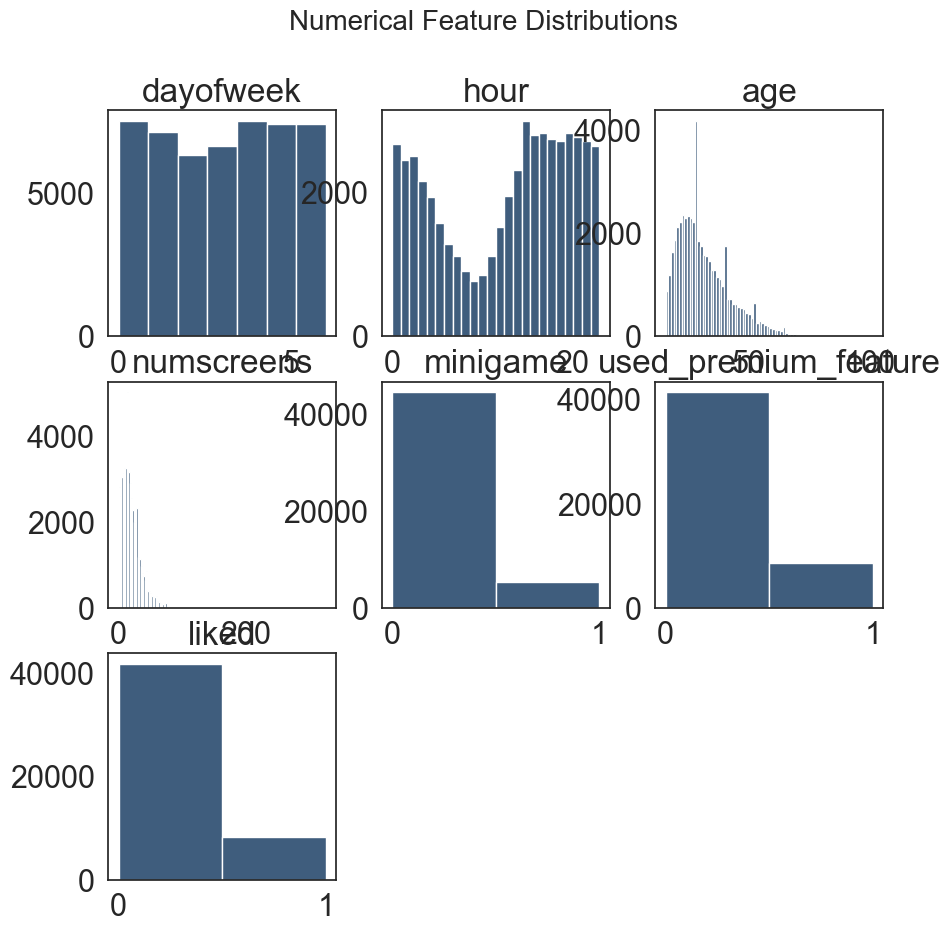

In [384]:
plt.figure(figsize=(10, 10))
plt.suptitle("Numerical Feature Distributions", fontsize=20)

for i in range(0, app_data_df2.shape[1]):
    plt.subplot(3, 3, i+1)
    f = plt.gca()
    f.set_title(app_data_df2.columns[i])

    unique_vals_size = np.size(app_data_df2.iloc[:, i].unique())
    plt.hist(app_data_df2.iloc[:, i], bins=unique_vals_size, color='#3F5D7D')

    


### Feature Correlation with Label
* Get feature correlation with label
* How each feature affect the label

<Axes: title={'center': 'Correlation with Label'}>

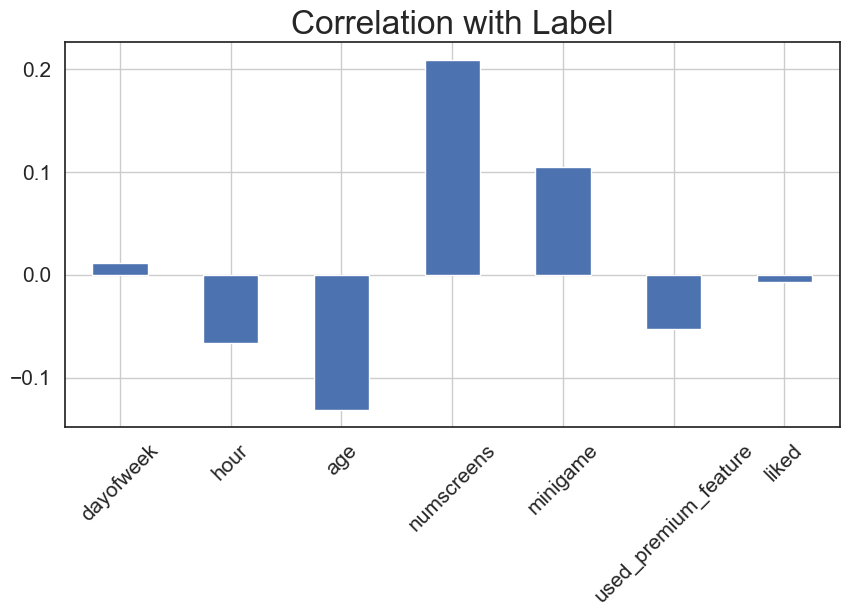

In [385]:
app_data_df2.corrwith(app_data_df.enrolled).plot.bar(figsize=(10, 5),
                                                     title="Correlation with Label",
                                                     fontsize=15,
                                                     rot=45,
                                                     grid=True)

### Feature Correlation Matrix
* Feature correlation with each other
* Use **heatmap**

<Axes: >

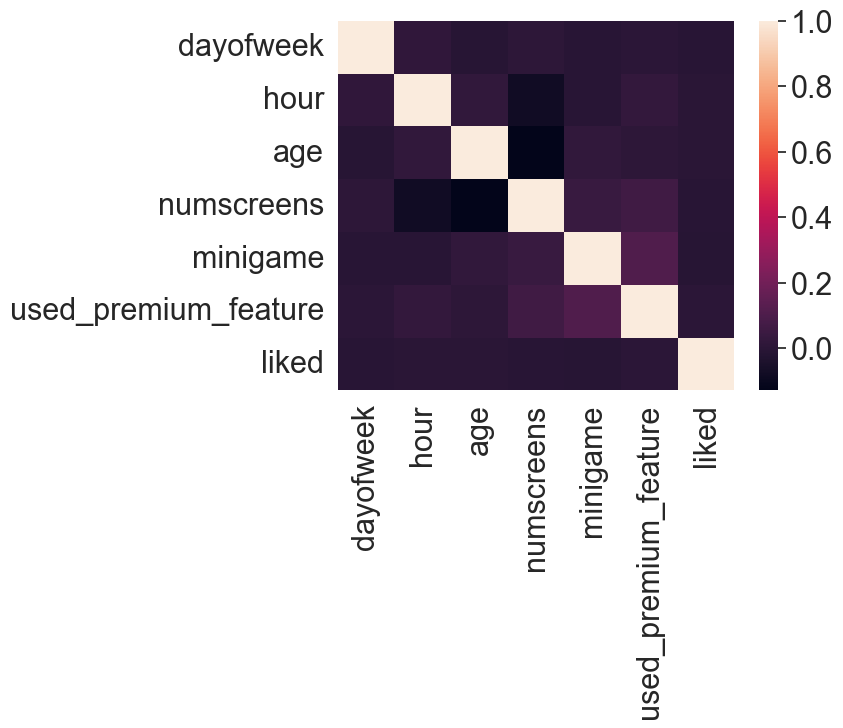

In [386]:
# Set figure background
sn.set(style="white", font_scale=2)

# Compute the correlation matrix
corr = app_data_df2.corr()

# Draw the heatmap
sn.heatmap(corr)

## Feature Engineering

In [387]:
# Get type of each column
app_data_df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int64
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

### First Open - Enrolled Time
We currently have features: `first_open` & `enrolled_date`<br>
Need to create a new feature: `first_open_to_enroll`<br>
So that we could utilize this new feature to set a cut-off time in order to determine *whether a user is enrolled or not within a time period*.


* [Add Feature (first open - enrolled time)](#Add-feature-first-open---enrolled-time)
* [Get New Feature Distribution](#get-new-feature-distribution)
* [Zoom In Distribution](#zoom-in-distribution)
* [Set Cut-off time](#set-cut-off-time)

#### Add Feature (first open - enrolled time)

In [388]:
app_data_df["first_open"] = [parser.parse(row) for row in app_data_df["first_open"]]
app_data_df["enrolled_date"] = [parser.parse(row) if isinstance(row, str) else row for row in app_data_df["enrolled_date"]]

In [389]:
app_data_df["first_open_to_enroll"] = (app_data_df["enrolled_date"] - app_data_df["first_open"]).astype("timedelta64[s]")
app_data_df["first_open_to_enroll"].dtype

dtype('<m8[s]')

In [390]:
app_data_df["first_open_to_enroll"].dropna().head()

3    0 days 00:03:03
4    0 days 00:05:49
5    0 days 00:00:47
8   38 days 08:02:52
9    0 days 00:09:42
Name: first_open_to_enroll, dtype: timedelta64[s]

In [391]:
app_data_df["first_open_to_enroll_hour"] = (app_data_df["first_open_to_enroll"] / np.timedelta64(1, 'h')).astype(float)
app_data_df["first_open_to_enroll_hour"].dtype

dtype('float64')

#### Get New Feature Distribution

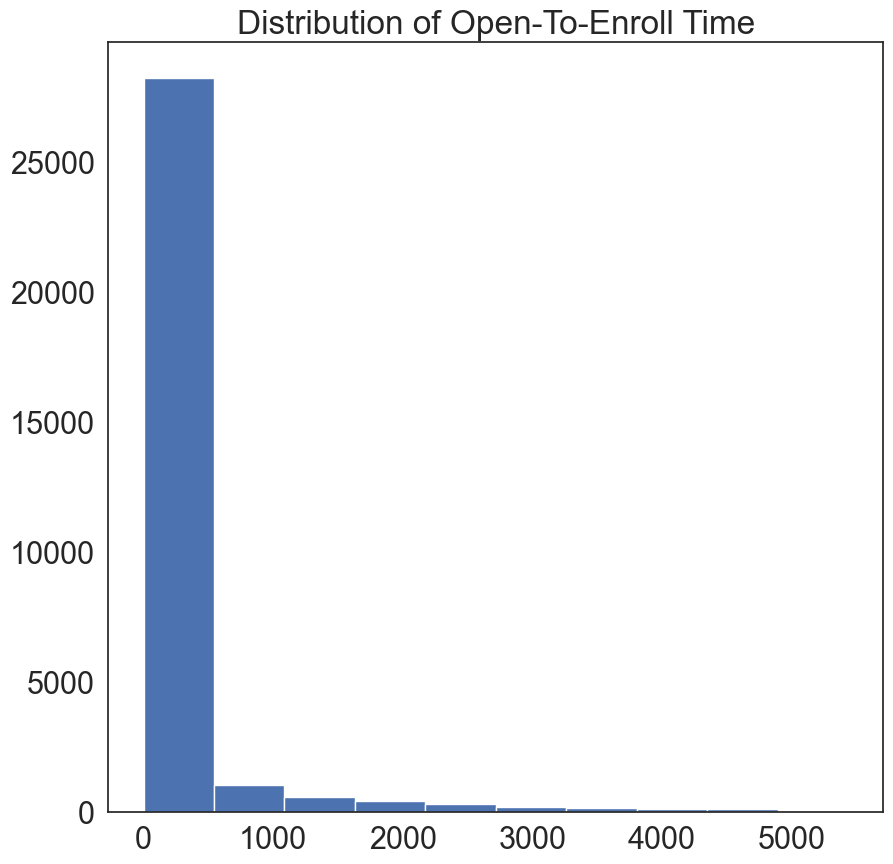

In [392]:
plt.figure(figsize=(10, 10))
plt.hist(app_data_df["first_open_to_enroll_hour"].dropna())
plt.title("Distribution of Open-To-Enroll Time")
plt.show()

#### Zoom In Distribution

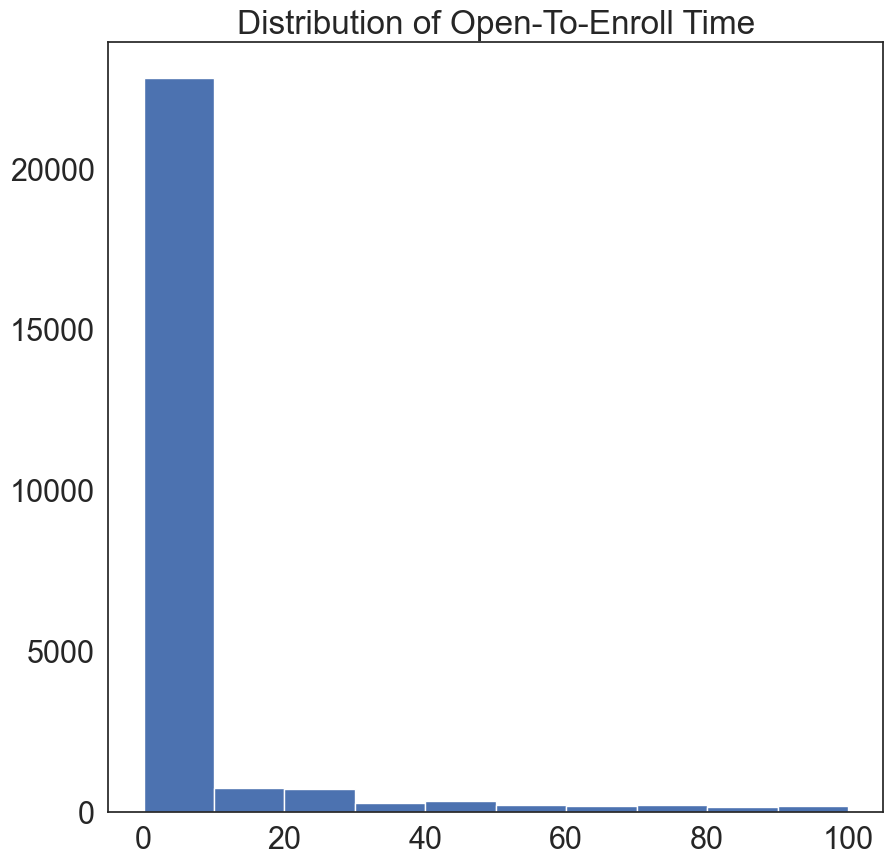

In [393]:
plt.figure(figsize=(10, 10))
plt.hist(app_data_df["first_open_to_enroll_hour"].dropna(), range=[0, 100])
plt.title("Distribution of Open-To-Enroll Time")
plt.show()

#### Set Cut-off time

Looks like we could cut-ff at 50 hours (set as 48 hrs)

We need a cut-off time to determine whether a user has enrolled or not

In [394]:
app_data_df.loc[app_data_df.first_open_to_enroll_hour > 48, "enrolled"] = 0

In [395]:
app_data_df = app_data_df.drop(columns=['first_open_to_enroll', 'first_open_to_enroll_hour', 'enrolled_date', 'first_open'])

### Screen List to Screen Cols

`screen_list` col is a list, would like to convert it to cols where each screen as a col<br>

To avoid creating too many cols, we could only select the top few screens<br>

Based on another dataset `top_screens_df`, we could select the top screens



In [396]:
top_screens_df.head()

,Unnamed: 0,top_screens
0,0,Loan2
1,1,location
2,2,Institutions
3,3,Credit3Container
4,4,VerifyPhone


In [397]:
app_data_df['screen_list'].head()

0    idscreen,joinscreen,Cycle,product_review,ScanP...
1    joinscreen,product_review,product_review2,Scan...
2                                    Splash,Cycle,Loan
3    product_review,Home,product_review,Loan3,Finan...
4    idscreen,joinscreen,Cycle,Credit3Container,Sca...
Name: screen_list, dtype: object

In [398]:
top_screens = top_screens_df['top_screens'].values
len(top_screens)

58

In [399]:
app_data_df["screen_list"] = app_data_df["screen_list"].astype(str) + ','

for sc in top_screens:
    app_data_df[sc] = app_data_df["screen_list"].str.contains(sc).astype(int)
    app_data_df["screen_list"] = app_data_df["screen_list"].str.replace(sc+",", "")

app_data_df.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked,...,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker
0,235136,3,2,23,"joinscreen,product_review,ScanPreview,VerifyTo...",15,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,333588,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,254414,1,19,23,,3,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,"product_review,Home,product_review,ReferralCon...",40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,51549,1,18,31,"joinscreen,ScanPreview,VerifySSN,Home,SelectIn...",32,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [400]:
app_data_df["num_other_screen"] = app_data_df["screen_list"].str.count(",")
app_data_df["num_other_screen"].head()

0     7
1     5
2     0
3     6
4    10
Name: num_other_screen, dtype: int64

In [401]:
app_data_df = app_data_df.drop(columns=["screen_list"])

In [402]:
app_data_df.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,Loan2,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,num_other_screen
0,235136,3,2,23,15,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,7
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6
4,51549,1,18,31,32,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,10


### Funnels

Aggregate correlated screens into funnels

In [403]:
savings_screens = [ "Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]

cm_screens = [ "Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]

cc_screens = [ "CC1",
               "CC1Category",
               "CC3"]

loan_screens = [ "Loan",
                 "Loan2",
                 "Loan3",
                 "Loan4"]

app_data_df["savings_screens_count"] = app_data_df[savings_screens].sum(axis=1)
app_data_df["cm_screens_count"] = app_data_df[cm_screens].sum(axis=1)
app_data_df["cc_screens_count"] = app_data_df[cc_screens].sum(axis=1)
app_data_df["loan_screens_count"] = app_data_df[loan_screens].sum(axis=1)

app_data_df = app_data_df.drop(columns = savings_screens + cm_screens + cc_screens + loan_screens)
app_data_df.head()



,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,num_other_screen,savings_screens_count,cm_screens_count,cc_screens_count,loan_screens_count
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


## Data Pre-Processing

### Extract Label

Extract label from dataset

In [404]:
app_data_df.shape

(50000, 50)

In [405]:
label = app_data_df["enrolled"]
app_data_df = app_data_df.drop(columns="enrolled").dropna()
app_data_df.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,location,Institutions,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,num_other_screen,savings_screens_count,cm_screens_count,cc_screens_count,loan_screens_count
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,1,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,0,1,0,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,0,1,...,0,0,0,0,0,10,0,2,0,1


In [406]:
app_data_df.shape

(50000, 49)

### Train Test Split

In [407]:
from sklearn.model_selection import train_test_split

In [408]:
X_train, X_test, y_train, y_test = train_test_split(app_data_df, 
                                                    label, 
                                                    test_size=0.2)

In [409]:
train_identifier = X_train["user"]
X_train = X_train.drop(columns="user")

test_identifier = X_test["user"]
X_test = X_test.drop(columns="user")

### Feature Normalization

In [410]:
from sklearn.preprocessing import StandardScaler

In [411]:
sc_X = StandardScaler()

X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.fit_transform(X_test))

X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values

X_train2.index = X_train.index.values
X_test2.index = X_test.index.values

X_train = X_train2
X_test = X_test2

## Model Building

### Train

In [412]:
from sklearn.linear_model import LogisticRegression

In [413]:
# Normal logistic regression
classifier_normal = LogisticRegression(random_state=0)

# L1 logistic regression
classifier_l1 = LogisticRegression(random_state=0, penalty="l1", solver="liblinear")

In [414]:
classifier_normal.fit(X_train, y_train)
classifier_l1.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

### Predict

In [415]:
y_predict_normal = classifier_normal.predict(X_test)
y_predict_l1 = classifier_l1.predict(X_test)

### Evaluate

In [416]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

**Accuracy** shows how often a classification ML model is correct overall. 

<img src="images/accuracy.png" alt="drawing" width="300"/>

In [417]:
accuracy_score_normal = accuracy_score(y_test, y_predict_normal)
accuracy_score_l1 = accuracy_score(y_test, y_predict_l1)
print(f"accuracy_score_normal: {accuracy_score_normal}, accuracy_score_l1: {accuracy_score_l1}")

accuracy_score_normal: 0.77, accuracy_score_l1: 0.7699


**Precision** shows how often an ML model is correct when predicting the target class.

<img src="images/precision.png" alt="drawing" width="300"/>

In [418]:
precision_score_normal = precision_score(y_test, y_predict_normal)
precision_score_l1 = precision_score(y_test, y_predict_l1)
print(f"precision_score_normal: {precision_score_normal}, precision_score_l1: {precision_score_l1}")

precision_score_normal: 0.765154556403051, precision_score_l1: 0.7651074081509737


**Recall** shows whether an ML model can find all objects of the target class. 

<img src="images/recall.png" alt="drawing" width="300"/>

In [419]:
recall_score_normal = recall_score(y_test, y_predict_normal)
recall_score_l1 = recall_score(y_test, y_predict_l1)
print(f"recall_score_normal: {recall_score_normal}, recall_score_l1: {recall_score_l1}")

recall_score_normal: 0.7713476325374342, recall_score_l1: 0.7711452853095913


F1 Score

<img src="images/f1_score.png" alt="drawing" width="300"/>

In [420]:
f1_score_normal = f1_score(y_test, y_predict_normal)
f1_score_l1 = f1_score(y_test, y_predict_l1)
print(f"f1_score_normal: {f1_score_normal}, f1_score_l1: {f1_score_l1}")

f1_score_normal: 0.7682386134623136, f1_score_l1: 0.7681144815076086


Confusion Matrix

In [421]:
cm_normal = confusion_matrix(y_test, y_predict_normal)
cm_l1 = confusion_matrix(y_test, y_predict_l1)

[Text(0.5, 5.049999999999999, 'Actual'), Text(32.25, 0.5, 'Prediction')]

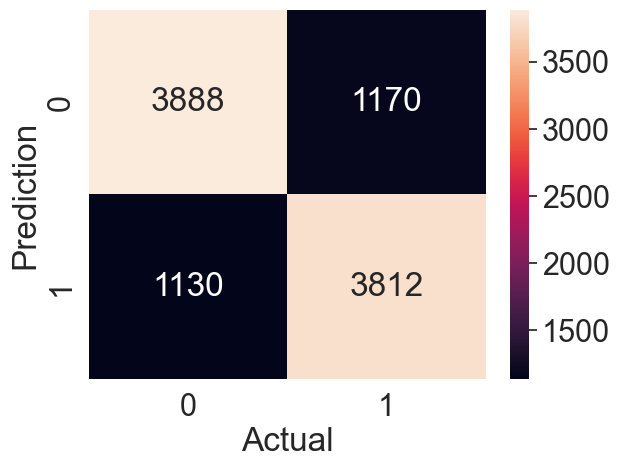

In [422]:
ax_normal = sn.heatmap(cm_normal, annot=True, fmt="d")
ax_normal.set(xlabel='Actual', ylabel='Prediction')

[Text(0.5, 5.049999999999999, 'Actual'), Text(32.25, 0.5, 'Prediction')]

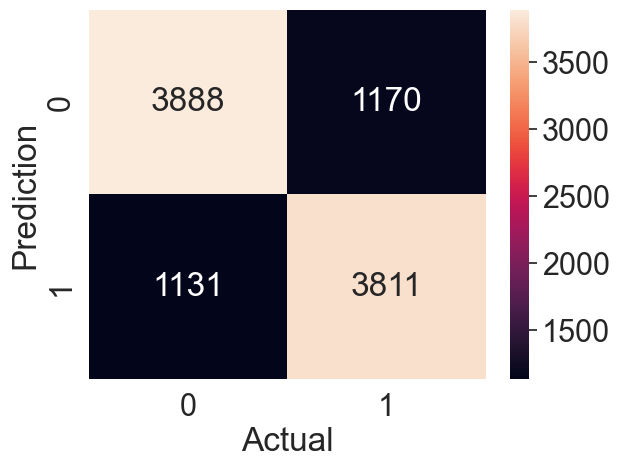

In [423]:
ax_l1 = sn.heatmap(cm_l1, annot=True, fmt="d")
ax_l1.set(xlabel='Actual', ylabel='Prediction')

## Model Conclusion

Format the final results

In [424]:
# Concate them in cols
final_results = pd.concat([y_test, test_identifier], axis=1).dropna()

In [425]:
final_results['predicted_res'] = y_predict_l1 #(or y_predict_normal)
final_results[['user', 'enrolled', 'predicted_res']].reset_index(drop=True).head(20)

,user,enrolled,predicted_res
0,298217,0,0
1,163245,0,0
2,234408,0,1
3,146245,1,1
4,140246,0,0
5,64364,1,1
6,99024,1,1
7,363188,0,0
8,54333,0,0
9,95017,0,0
